In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [3]:
MODELS = [os.path.join('analysis_checkpoints_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_checkpoints_v7.0'))]

In [4]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/v7.0/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            # keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            # keys_to_remove.extend(['x', 'y'])

            # for k in keys_to_remove:
            #     del test_set_results['data'][k]

Loading analysis_checkpoints_v7.0/v7.0_checkpoint-100000 results: 100%|██████████| 6/6 [00:27<00:00,  4.60s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-900000 results: 100%|██████████| 6/6 [00:30<00:00,  5.10s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-1500000 results: 100%|██████████| 6/6 [00:29<00:00,  4.90s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-1100000 results: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-1000000 results: 100%|██████████| 6/6 [00:28<00:00,  4.70s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-1200000 results: 100%|██████████| 6/6 [00:31<00:00,  5.21s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-800000 results: 100%|██████████| 6/6 [00:28<00:00,  4.72s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-600000 results: 100%|██████████| 6/6 [00:33<00:00,  5.51s/it]
Loading analysis_checkpoints_v7.0/v7.0_checkpoint-700000 results: 100%|██████████| 6/6 [00:30<00:00,

In [10]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 6/6 [00:00<00:00, 6037.87it/s]


In [11]:
# Replace 'beam_val_' with 'val_beam' in columns where 'beam_val_' is present
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        columns_before = set(data.keys())
        changed_columns = []
        for k in columns_before:
            if 'beam_val_' in k:
                data[k.replace('beam_val_', 'val_beam_')] = data[k]
                changed_columns.append(k)

        for k in changed_columns:
            del data[k]

100%|██████████| 6/6 [00:00<00:00, 9157.87it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_3446/343701655.py:14: RuntimeWarning: All-NaN slice encountered
  results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
100%|██████████| 6/6 [00:00<00:00,  8.62it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 6/6 [00:00<00:00, 26.54it/s]


In [14]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        print(f'Processing {model} {test_set}')
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([max(1 - r2, np.finfo(np.float32).eps) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 train
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 val
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 feynman
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 soose_nc
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 nguyen
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-100000 pool_15
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-900000 train
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-900000 val
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-900000 feynman
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-900000 soose_nc
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-900000 nguyen
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-900000 pool_15
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1500000 train
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1500000 val
Processing analysis_checkpoints_v7.0/v7.0_checkpoint-1500000 fey

In [15]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'L_inf_best_beam',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best

In [16]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [17]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [18]:
from functools import partial

In [19]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [20]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_checkpoints_v7.0/v7.0_checkpoint-100000 train:   6%|▌         | 3/49 [00:00<00:04,  9.49it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 train: 100%|██████████| 49/49 [00:05<00:00,  9.26it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 val: 100%|██████████| 49/49 [00:07<00:00,  6.69it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 feynman: 100%|██████████| 49/49 [00:06<00:00,  7.66it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 soose_nc: 100%|██████████| 49/49 [00:06<00:00,  7.93it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 nguyen: 100%|██████████| 49/49 [00:05<00:00,  8.51it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-100000 pool_15: 100%|██████████| 49/49 [00:05<00:00,  8.82it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-900000 train: 100%|██████████| 49/

In [21]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [22]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","1.0 (1.0, 1.0)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.999 (0.997, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"1.0 (1.0, 1.0)","0.999 (0.997, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [23]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.485 (0.455, 0.514)","0.499 (0.466, 0.53)","0.732 (0.703, 0.76)","0.418 (0.388, 0.448)","0.52 (0.491, 0.551)","0.465 (0.434, 0.494)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"0.714 (0.685, 0.743)","0.744 (0.717, 0.769)","0.854 (0.831, 0.875)","0.794 (0.767, 0.817)","0.873 (0.851, 0.892)","0.602 (0.571, 0.631)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"0.749 (0.722, 0.775)","0.729 (0.701, 0.756)","0.884 (0.864, 0.903)","0.806 (0.781, 0.83)","0.852 (0.83, 0.874)","0.652 (0.622, 0.682)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.801 (0.773, 0.826)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.719 (0.692, 0.749)","0.727 (0.697, 0.755)","0.866 (0.844, 0.888)","0.825 (0.801, 0.849)","0.849 (0.828, 0.871)","0.609 (0.578, 0.639)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"0.736 (0.71, 0.765)","0.718 (0.692, 0.747)","0.892 (0.873, 0.912)","0.808 (0.783, 0.831)","0.91 (0.892, 0.928)","0.627 (0.597, 0.657)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"0.688 (0.659, 0.715)","0.716 (0.691, 0.745)","0.869 (0.849, 0.889)","0.789 (0.764, 0.814)","0.83 (0.806, 0.853)","0.608 (0.58, 0.639)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.655 (0.627, 0.685)","0.698 (0.67, 0.724)","0.837 (0.814, 0.86)","0.75 (0.725, 0.775)","0.855 (0.833, 0.878)","0.585 (0.554, 0.614)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.68 (0.648, 0.708)","0.706 (0.676, 0.733)","0.85 (0.826, 0.869)","0.766 (0.74, 0.792)","0.842 (0.821, 0.866)","0.604 (0.575, 0.633)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.634 (0.602, 0.662)","0.647 (0.617, 0.674)","0.83 (0.808, 0.853)","0.717 (0.69, 0.745)","0.78 (0.753, 0.805)","0.562 (0.532, 0.594)"


In [24]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.746 (0.718, 0.772)","0.772 (0.745, 0.798)","0.849 (0.825, 0.872)","0.628 (0.598, 0.655)","0.751 (0.724, 0.776)","0.689 (0.66, 0.718)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"0.885 (0.865, 0.904)","0.895 (0.877, 0.914)","0.926 (0.909, 0.942)","0.857 (0.836, 0.878)","0.984 (0.976, 0.992)","0.821 (0.797, 0.844)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"0.889 (0.869, 0.908)","0.872 (0.851, 0.893)","0.942 (0.925, 0.955)","0.88 (0.861, 0.899)","0.974 (0.964, 0.983)","0.816 (0.791, 0.84)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.866 (0.844, 0.888)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.876 (0.856, 0.896)","0.888 (0.871, 0.907)","0.946 (0.931, 0.96)","0.878 (0.857, 0.899)","0.983 (0.974, 0.991)","0.802 (0.777, 0.824)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"0.889 (0.868, 0.908)","0.871 (0.849, 0.892)","0.951 (0.935, 0.964)","0.879 (0.859, 0.9)","0.986 (0.979, 0.993)","0.823 (0.798, 0.845)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"0.848 (0.823, 0.869)","0.887 (0.867, 0.906)","0.937 (0.922, 0.951)","0.866 (0.846, 0.886)","0.979 (0.97, 0.987)","0.798 (0.773, 0.821)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.856 (0.834, 0.879)","0.896 (0.876, 0.914)","0.917 (0.899, 0.933)","0.831 (0.807, 0.854)","0.978 (0.968, 0.987)","0.775 (0.751, 0.799)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.883 (0.863, 0.902)","0.873 (0.852, 0.893)","0.931 (0.916, 0.946)","0.859 (0.836, 0.879)","0.976 (0.966, 0.985)","0.797 (0.772, 0.82)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.836 (0.812, 0.858)","0.86 (0.839, 0.882)","0.907 (0.888, 0.923)","0.819 (0.795, 0.842)","0.968 (0.957, 0.978)","0.762 (0.735, 0.788)"


In [25]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.285 (0.258, 0.311)","0.302 (0.275, 0.33)","0.621 (0.59, 0.651)","0.227 (0.2, 0.253)","0.296 (0.267, 0.324)","0.218 (0.193, 0.244)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"0.506 (0.476, 0.538)","0.546 (0.516, 0.575)","0.704 (0.674, 0.733)","0.662 (0.634, 0.691)","0.716 (0.689, 0.744)","0.349 (0.32, 0.379)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"0.574 (0.544, 0.606)","0.517 (0.486, 0.547)","0.772 (0.746, 0.798)","0.704 (0.675, 0.733)","0.72 (0.692, 0.75)","0.348 (0.319, 0.379)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.678 (0.65, 0.707)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.534 (0.504, 0.565)","0.529 (0.498, 0.558)","0.763 (0.736, 0.791)","0.704 (0.674, 0.732)","0.694 (0.665, 0.723)","0.331 (0.301, 0.36)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"0.528 (0.498, 0.559)","0.52 (0.49, 0.551)","0.77 (0.745, 0.797)","0.688 (0.66, 0.72)","0.764 (0.738, 0.79)","0.338 (0.309, 0.367)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"0.479 (0.448, 0.512)","0.515 (0.485, 0.545)","0.742 (0.714, 0.77)","0.653 (0.625, 0.682)","0.642 (0.61, 0.672)","0.342 (0.313, 0.37)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.458 (0.427, 0.488)","0.52 (0.491, 0.55)","0.71 (0.684, 0.738)","0.6 (0.569, 0.63)","0.677 (0.645, 0.705)","0.304 (0.273, 0.332)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.48 (0.451, 0.513)","0.503 (0.473, 0.533)","0.73 (0.7, 0.756)","0.618 (0.589, 0.648)","0.675 (0.645, 0.701)","0.287 (0.261, 0.316)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.402 (0.371, 0.433)","0.457 (0.427, 0.491)","0.688 (0.66, 0.719)","0.538 (0.509, 0.57)","0.621 (0.591, 0.652)","0.296 (0.267, 0.323)"


#### Numeric Error

In [26]:
m = 'fvu'
sm = '97.5p'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"1.0 (0.998, 1.037)","0.997 (0.986, 1.0)","1.0 (0.988, 1.019)","1.573 (1.393, 1.67)","0.987 (0.967, 0.993)","0.999 (0.995, 1.0)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"0.997 (0.976, 1.0)","0.982 (0.948, 0.997)","0.92 (0.698, 0.961)","1.005 (1.0, 1.205)","0.006 (0.002, 0.028)","1.0 (0.998, 1.004)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"0.972 (0.905, 0.996)","0.998 (0.982, 1.002)","0.914 (0.796, 0.978)","1.097 (1.0, 1.206)","0.06 (0.012, 0.087)","1.0 (0.997, 1.004)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","1.042 (1.0, 1.19)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.994 (0.979, 0.999)","0.982 (0.942, 0.998)","0.789 (0.308, 0.932)","1.012 (1.0, 1.285)","0.016 (0.007, 0.046)","1.0 (0.988, 1.025)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"0.994 (0.96, 0.999)","0.998 (0.973, 1.0)","0.85 (0.312, 0.955)","1.003 (0.999, 1.107)","0.012 (0.003, 0.032)","1.001 (0.997, 1.016)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"0.992 (0.971, 0.997)","0.931 (0.89, 0.999)","0.851 (0.496, 0.975)","1.033 (1.001, 1.358)","0.026 (0.008, 0.075)","1.0 (0.998, 1.002)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.999 (0.986, 1.001)","0.984 (0.914, 0.996)","0.957 (0.794, 0.986)","1.168 (1.009, 1.314)","0.043 (0.019, 0.092)","1.001 (0.998, 1.015)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.993 (0.935, 0.998)","0.991 (0.959, 0.998)","0.95 (0.74, 0.974)","1.045 (1.0, 1.207)","0.048 (0.016, 0.102)","1.0 (0.996, 1.001)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.999 (0.987, 1.001)","0.993 (0.939, 1.0)","0.952 (0.895, 0.981)","1.205 (1.005, 1.411)","0.082 (0.027, 0.174)","1.0 (0.999, 1.002)"


#### Time

In [27]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"2.151 (2.111, 2.195)","2.066 (2.047, 2.087)","1.996 (1.975, 2.024)","2.109 (2.09, 2.139)","1.964 (1.95, 1.977)","2.2 (2.151, 2.264)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"2.003 (1.99, 2.023)","2.001 (1.987, 2.016)","2.06 (2.037, 2.08)","2.049 (2.013, 2.087)","2.059 (2.039, 2.089)","2.158 (2.128, 2.196)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"2.059 (2.036, 2.079)","2.129 (2.082, 2.178)","2.046 (2.02, 2.073)","2.052 (2.026, 2.098)","2.05 (2.028, 2.071)","2.14 (2.109, 2.18)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","2.111 (2.08, 2.138)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"2.094 (2.07, 2.138)","2.097 (2.07, 2.136)","2.08 (2.062, 2.102)","2.002 (1.988, 2.017)","2.053 (2.023, 2.085)","2.187 (2.144, 2.231)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"2.079 (2.054, 2.114)","2.065 (2.037, 2.084)","1.964 (1.95, 1.977)","2.067 (2.039, 2.113)","2.032 (2.012, 2.058)","2.165 (2.14, 2.208)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"2.14 (2.105, 2.185)","2.059 (2.031, 2.099)","2.042 (2.012, 2.097)","2.076 (2.042, 2.138)","2.042 (2.007, 2.067)","2.138 (2.099, 2.173)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"2.098 (2.056, 2.135)","2.024 (1.993, 2.054)","2.044 (2.014, 2.085)","2.013 (1.976, 2.055)","2.084 (2.047, 2.129)","2.166 (2.129, 2.208)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"2.071 (2.036, 2.134)","2.118 (2.069, 2.181)","1.988 (1.963, 2.022)","2.017 (1.985, 2.077)","2.041 (2.0, 2.093)","2.176 (2.128, 2.259)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"2.182 (2.127, 2.235)","2.123 (2.08, 2.192)","2.124 (2.088, 2.165)","2.075 (2.041, 2.116)","2.2 (2.169, 2.236)","2.276 (2.207, 2.356)"


In [28]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"2.152 (2.116, 2.195)","2.068 (2.049, 2.089)","1.997 (1.974, 2.025)","2.109 (2.092, 2.14)","1.964 (1.952, 1.977)","2.197 (2.145, 2.263)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"2.003 (1.99, 2.022)","2.001 (1.987, 2.015)","2.061 (2.037, 2.08)","2.049 (2.013, 2.087)","2.059 (2.037, 2.087)","2.156 (2.125, 2.198)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"2.059 (2.036, 2.077)","2.136 (2.082, 2.179)","2.046 (2.021, 2.07)","2.052 (2.026, 2.099)","2.05 (2.029, 2.069)","2.14 (2.109, 2.178)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","2.112 (2.081, 2.138)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"2.094 (2.066, 2.138)","2.097 (2.064, 2.136)","2.08 (2.06, 2.102)","2.003 (1.988, 2.018)","2.054 (2.023, 2.086)","2.188 (2.144, 2.226)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"2.079 (2.052, 2.115)","2.064 (2.037, 2.085)","1.964 (1.95, 1.978)","2.067 (2.037, 2.107)","2.031 (2.01, 2.06)","2.164 (2.14, 2.204)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"2.139 (2.099, 2.183)","2.059 (2.032, 2.099)","2.042 (2.012, 2.089)","2.076 (2.038, 2.139)","2.043 (2.009, 2.067)","2.139 (2.101, 2.178)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"2.1 (2.057, 2.133)","2.025 (1.995, 2.053)","2.043 (2.013, 2.084)","2.013 (1.977, 2.055)","2.085 (2.046, 2.128)","2.168 (2.129, 2.213)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"2.071 (2.03, 2.136)","2.116 (2.069, 2.182)","1.993 (1.966, 2.021)","2.014 (1.981, 2.072)","2.038 (1.998, 2.086)","2.174 (2.13, 2.259)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"2.182 (2.125, 2.23)","2.125 (2.08, 2.197)","2.124 (2.091, 2.166)","2.075 (2.041, 2.115)","2.2 (2.169, 2.235)","2.275 (2.212, 2.366)"


#### Text Metrics

In [29]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"8.374 (7.839, 9.192)","8.304 (7.361, 9.272)","3.354 (2.984, 3.928)","5.765 (5.308, 6.196)","10.229 (9.333, 11.137)","23.751 (19.826, 26.706)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"5.069 (4.653, 5.659)","4.619 (4.053, 5.537)","2.728 (2.486, 3.101)","2.171 (2.028, 2.335)","4.935 (4.498, 5.474)","16.852 (14.52, 22.33)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"4.148 (3.779, 4.529)","4.238 (3.724, 4.662)","2.177 (1.977, 2.347)","1.874 (1.77, 1.997)","5.34 (4.556, 6.477)","16.781 (14.045, 19.709)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","2.165 (1.986, 2.378)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"4.771 (4.288, 5.172)","4.469 (4.077, 5.174)","2.219 (2.091, 2.414)","2.069 (1.932, 2.232)","5.261 (4.394, 6.252)","18.136 (15.225, 21.159)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"4.937 (4.375, 5.337)","4.787 (4.245, 5.453)","2.405 (2.222, 2.751)","2.005 (1.874, 2.156)","5.36 (4.482, 6.454)","14.36 (12.688, 17.061)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"5.16 (4.698, 5.841)","4.567 (4.132, 5.204)","2.593 (2.28, 3.035)","2.391 (2.154, 2.563)","6.84 (5.998, 8.093)","17.93 (14.87, 21.536)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"5.572 (4.908, 6.124)","4.652 (4.195, 5.212)","2.79 (2.464, 3.206)","2.618 (2.408, 2.868)","5.474 (4.665, 6.053)","21.064 (16.883, 24.584)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"5.085 (4.524, 5.684)","4.735 (4.256, 5.159)","2.8 (2.425, 3.173)","2.646 (2.425, 2.852)","5.772 (5.224, 6.328)","18.589 (15.354, 21.765)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"6.554 (5.8, 7.449)","5.74 (5.081, 6.356)","3.001 (2.653, 3.382)","2.974 (2.762, 3.286)","7.164 (5.938, 8.183)","19.798 (16.69, 24.041)"


In [30]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"17.241 (16.691, 17.806)","16.943 (16.388, 17.583)","11.846 (11.256, 12.449)","14.712 (14.266, 15.207)","18.055 (17.446, 18.638)","23.999 (23.3, 24.676)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"15.054 (14.451, 15.681)","14.013 (13.388, 14.586)","12.186 (11.596, 12.824)","8.215 (7.642, 8.75)","12.146 (11.45, 12.872)","22.414 (21.696, 23.219)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"14.216 (13.689, 14.805)","14.565 (13.968, 15.156)","10.726 (10.136, 11.325)","7.792 (7.29, 8.351)","12.67 (11.931, 13.41)","22.279 (21.44, 22.994)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","8.177 (7.654, 8.722)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"14.588 (13.964, 15.158)","14.744 (14.127, 15.381)","10.418 (9.866, 11.012)","7.855 (7.319, 8.37)","12.84 (12.161, 13.602)","22.59 (21.859, 23.303)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"14.71 (14.079, 15.306)","14.715 (14.139, 15.313)","10.796 (10.248, 11.404)","7.821 (7.305, 8.375)","11.997 (11.339, 12.665)","22.07 (21.337, 22.761)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"15.353 (14.768, 15.97)","14.852 (14.265, 15.44)","10.85 (10.216, 11.42)","8.495 (7.954, 9.016)","12.484 (11.72, 13.252)","22.489 (21.774, 23.253)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"15.734 (15.148, 16.308)","14.404 (13.819, 14.973)","11.843 (11.236, 12.422)","9.198 (8.655, 9.682)","13.027 (12.369, 13.768)","22.619 (21.848, 23.326)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"15.265 (14.618, 15.841)","14.802 (14.216, 15.399)","11.203 (10.613, 11.795)","9.097 (8.561, 9.648)","12.69 (11.996, 13.441)","23.462 (22.657, 24.255)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"16.246 (15.647, 16.768)","15.227 (14.623, 15.833)","11.656 (11.04, 12.287)","9.883 (9.369, 10.385)","13.514 (12.787, 14.324)","23.05 (22.235, 23.858)"


In [31]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.84 (0.834, 0.848)","0.847 (0.84, 0.854)","0.892 (0.886, 0.898)","0.793 (0.784, 0.802)","0.721 (0.712, 0.731)","0.819 (0.812, 0.825)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"0.877 (0.87, 0.884)","0.885 (0.878, 0.892)","0.909 (0.902, 0.914)","0.898 (0.889, 0.906)","0.831 (0.822, 0.841)","0.855 (0.848, 0.862)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"0.886 (0.879, 0.892)","0.886 (0.879, 0.893)","0.923 (0.917, 0.928)","0.908 (0.9, 0.916)","0.831 (0.822, 0.84)","0.853 (0.846, 0.859)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.9 (0.891, 0.908)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.886 (0.88, 0.893)","0.879 (0.872, 0.885)","0.92 (0.915, 0.926)","0.902 (0.894, 0.909)","0.832 (0.823, 0.842)","0.848 (0.841, 0.855)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"0.882 (0.876, 0.888)","0.885 (0.877, 0.892)","0.916 (0.91, 0.921)","0.907 (0.899, 0.915)","0.839 (0.83, 0.849)","0.856 (0.849, 0.862)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"0.877 (0.87, 0.884)","0.883 (0.875, 0.889)","0.915 (0.91, 0.921)","0.891 (0.883, 0.9)","0.828 (0.819, 0.837)","0.847 (0.841, 0.854)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.872 (0.866, 0.879)","0.884 (0.877, 0.89)","0.906 (0.899, 0.911)","0.882 (0.873, 0.891)","0.82 (0.811, 0.83)","0.844 (0.837, 0.851)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.876 (0.869, 0.883)","0.881 (0.874, 0.887)","0.91 (0.904, 0.916)","0.887 (0.878, 0.896)","0.828 (0.819, 0.838)","0.84 (0.833, 0.846)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.866 (0.858, 0.873)","0.868 (0.861, 0.874)","0.902 (0.896, 0.908)","0.876 (0.867, 0.884)","0.813 (0.803, 0.822)","0.84 (0.833, 0.847)"


In [32]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"0.511 (0.497, 0.524)","0.532 (0.518, 0.548)","0.683 (0.667, 0.698)","0.532 (0.516, 0.547)","0.387 (0.371, 0.402)","0.443 (0.432, 0.456)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"0.611 (0.596, 0.626)","0.639 (0.625, 0.655)","0.71 (0.696, 0.726)","0.765 (0.747, 0.78)","0.617 (0.598, 0.636)","0.515 (0.501, 0.529)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"0.646 (0.631, 0.661)","0.641 (0.627, 0.656)","0.755 (0.74, 0.77)","0.786 (0.77, 0.801)","0.612 (0.592, 0.631)","0.521 (0.506, 0.536)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","0.769 (0.753, 0.786)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"0.635 (0.619, 0.651)","0.63 (0.615, 0.643)","0.742 (0.728, 0.757)","0.77 (0.755, 0.787)","0.625 (0.604, 0.645)","0.512 (0.496, 0.525)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"0.63 (0.616, 0.645)","0.628 (0.613, 0.644)","0.743 (0.728, 0.757)","0.783 (0.766, 0.799)","0.634 (0.615, 0.654)","0.517 (0.502, 0.531)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"0.607 (0.592, 0.623)","0.627 (0.612, 0.643)","0.742 (0.727, 0.757)","0.754 (0.738, 0.771)","0.599 (0.58, 0.618)","0.509 (0.495, 0.524)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"0.601 (0.586, 0.617)","0.627 (0.613, 0.642)","0.708 (0.693, 0.723)","0.736 (0.72, 0.752)","0.608 (0.588, 0.627)","0.5 (0.486, 0.514)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"0.612 (0.597, 0.627)","0.62 (0.604, 0.636)","0.726 (0.71, 0.741)","0.742 (0.725, 0.758)","0.615 (0.596, 0.634)","0.491 (0.478, 0.504)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"0.581 (0.567, 0.596)","0.601 (0.586, 0.616)","0.706 (0.692, 0.722)","0.71 (0.693, 0.726)","0.573 (0.552, 0.591)","0.491 (0.477, 0.506)"


In [33]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,train,val,feynman,soose_nc,nguyen,pool_15
analysis_checkpoints_v7.0/v7.0_checkpoint-100000,"6.87 (6.665, 7.08)","6.618 (6.388, 6.823)","4.568 (4.356, 4.783)","5.441 (5.265, 5.625)","5.882 (5.682, 6.105)","9.765 (9.468, 10.052)"
analysis_checkpoints_v7.0/v7.0_checkpoint-900000,"5.857 (5.634, 6.092)","5.488 (5.256, 5.717)","4.529 (4.324, 4.73)","3.07 (2.882, 3.271)","4.12 (3.884, 4.358)","9.08 (8.769, 9.377)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,"5.612 (5.39, 5.851)","5.649 (5.423, 5.87)","3.986 (3.787, 4.201)","2.9 (2.707, 3.093)","4.21 (3.934, 4.437)","8.914 (8.619, 9.203)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,"nan (nan, nan)","nan (nan, nan)","nan (nan, nan)","3.051 (2.853, 3.256)","nan (nan, nan)","nan (nan, nan)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,"5.693 (5.48, 5.918)","5.686 (5.454, 5.924)","4.034 (3.833, 4.235)","2.917 (2.735, 3.114)","4.288 (4.015, 4.538)","9.046 (8.773, 9.332)"
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,"5.776 (5.548, 5.988)","5.681 (5.463, 5.908)","4.026 (3.822, 4.231)","2.923 (2.747, 3.14)","4.107 (3.862, 4.344)","8.831 (8.527, 9.114)"
analysis_checkpoints_v7.0/v7.0_checkpoint-800000,"5.983 (5.749, 6.23)","5.8 (5.588, 6.042)","3.998 (3.799, 4.22)","3.143 (2.949, 3.336)","4.251 (3.993, 4.499)","9.094 (8.803, 9.414)"
analysis_checkpoints_v7.0/v7.0_checkpoint-600000,"6.156 (5.92, 6.357)","5.706 (5.481, 5.946)","4.483 (4.286, 4.7)","3.391 (3.205, 3.582)","4.374 (4.133, 4.606)","9.084 (8.772, 9.381)"
analysis_checkpoints_v7.0/v7.0_checkpoint-700000,"5.985 (5.751, 6.217)","5.792 (5.576, 6.026)","4.273 (4.056, 4.476)","3.367 (3.164, 3.55)","4.276 (4.048, 4.527)","9.355 (9.049, 9.65)"
analysis_checkpoints_v7.0/v7.0_checkpoint-400000,"6.343 (6.143, 6.559)","5.928 (5.695, 6.156)","4.352 (4.138, 4.579)","3.649 (3.442, 3.84)","4.473 (4.22, 4.705)","9.177 (8.869, 9.466)"


In [34]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [35]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_checkpoints_v7.0/checkpoint-100000], [28.5\ (25.8, 31.1) <table_CI>], [30.2\ (27.5, 33.0) <table_CI>], [62.1\ (59.0, 65.1) <table_CI>], [22.7\ (20.0, 25.3) <table_CI>], [29.6\ (26.7, 32.4) <table_CI>], [21.8\ (19.3, 24.4) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-900000], [50.6\ (47.6, 53.8) <table_CI>], [*54.6\ (51.6, 57.5) <table_CI>*], [70.4\ (67.4, 73.3) <table_CI>], [*66.2\ (63.4, 69.1) <table_CI>*], [*71.6\ (68.9, 74.4) <table_CI>*], [*34.9\ (32.0, 37.9) <table_CI>*],
  [analysis_checkpoints_v7.0/checkpoint-1500000], [*57.4\ (54.4, 60.6) <tabl

In [36]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_checkpoints_v7.0/checkpoint-100000], [74.6\ (71.8, 77.2) <table_CI>], [77.2\ (74.5, 79.8) <table_CI>], [84.9\ (82.5, 87.2) <table_CI>], [62.8\ (59.8, 65.5) <table_CI>], [75.1\ (72.4, 77.6) <table_CI>], [68.9\ (66.0, 71.8) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-900000], [*88.5\ (86.5, 90.4) <table_CI>*], [*89.5\ (87.7, 91.4) <table_CI>*], [*92.6\ (90.9, 94.2) <table_CI>*], [*85.7\ (83.6, 87.8) <table_CI>*], [*98.4\ (97.6, 99.2) <table_CI>*], [*82.1\ (79.7, 84.4) <table_CI>*],
  [analysis_checkpoints_v7.0/checkpoint-1500000], [*88.9\ (86.9, 90.8) <

In [37]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_checkpoints_v7.0/checkpoint-100000], [6.87\ (6.67, 7.08) <table_CI>], [6.62\ (6.39, 6.82) <table_CI>], [4.57\ (4.36, 4.78) <table_CI>], [5.44\ (5.26, 5.62) <table_CI>], [5.88\ (5.68, 6.11) <table_CI>], [9.77\ (9.47, 10.05) <table_CI>],
  [analysis_checkpoints_v7.0/checkpoint-900000], [*5.86\ (5.63, 6.09) <table_CI>*], [*5.49\ (5.26, 5.72) <table_CI>*], [4.53\ (4.32, 4.73) <table_CI>], [*3.07\ (2.88, 3.27) <table_CI>*], [*4.12\ (3.88, 4.36) <table_CI>*], [*9.08\ (8.77, 9.38) <table_CI>*],
  [analysis_checkpoints_v7.0/checkpoint-1500000], [*5.61\ (5.39, 5.85) <t

# Aggregated

In [38]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [39]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_checkpoints_v7.0/v7.0_checkpoint-100000:   8%|▊         | 4/49 [00:00<00:09,  4.54it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_checkpoints_v7.0/v7.0_checkpoint-900000: 100%|██████████| 49/49 [00:11<00:00,  4.23it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-1500000: 100%|██████████| 49/49 [00:11<00:00,  4.22it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-1100000: 100%|██████████| 49/49 [00:05<00:00,  9.24it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-1000000: 100%|██████████| 49/49 [00:11<00:00,  4.26it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-1200000: 100%|██████████| 49/49 [00:11<00:00,  4.18it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-300000: 100%|██████████| 49/49 [00:12<00:00,  4.08it/s]
analysis_checkpoints_v7.0/v7.0_checkpoint-1400000: 100%|██████████| 49/49 [00:12<00:00,  4.04it/s]
analysis_checkpoints_

In [40]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [ ]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_checkpoints_v7.0/v7.0_checkpoint-100000,analysis_checkpoints_v7.0/v7.0_checkpoint-900000,analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,analysis_checkpoints_v7.0/v7.0_checkpoint-800000,analysis_checkpoints_v7.0/v7.0_checkpoint-600000,analysis_checkpoints_v7.0/v7.0_checkpoint-700000,analysis_checkpoints_v7.0/v7.0_checkpoint-400000,analysis_checkpoints_v7.0/v7.0_checkpoint-300000,analysis_checkpoints_v7.0/v7.0_checkpoint-1400000,analysis_checkpoints_v7.0/v7.0_checkpoint-500000,analysis_checkpoints_v7.0/v7.0_checkpoint-1300000,analysis_checkpoints_v7.0/v7.0_checkpoint-200000
FVU-eps_accuracy,"0.34 (0.327, 0.356)","0.608 (0.593, 0.623)","0.637 (0.621, 0.65)","0.678 (0.646, 0.708)","0.622 (0.608, 0.637)","0.64 (0.625, 0.656)","0.595 (0.579, 0.61)","0.573 (0.558, 0.587)","0.578 (0.561, 0.592)","0.536 (0.52, 0.551)","0.525 (0.51, 0.54)","0.633 (0.619, 0.648)","0.58 (0.565, 0.596)","0.642 (0.627, 0.657)","0.472 (0.457, 0.489)"
FVU-eps_accuracy_val,"0.338 (0.322, 0.352)","0.606 (0.59, 0.621)","0.635 (0.621, 0.651)","0.68 (0.65, 0.707)","0.619 (0.604, 0.634)","0.64 (0.624, 0.653)","0.595 (0.579, 0.609)","0.572 (0.556, 0.587)","0.578 (0.564, 0.593)","0.533 (0.516, 0.548)","0.523 (0.508, 0.538)","0.633 (0.62, 0.648)","0.578 (0.563, 0.594)","0.641 (0.626, 0.656)","0.47 (0.454, 0.485)"
NSRTS_accuracy_close_best_beam,"0.534 (0.518, 0.548)","0.78 (0.767, 0.794)","0.799 (0.786, 0.81)","0.801 (0.775, 0.825)","0.788 (0.776, 0.801)","0.81 (0.797, 0.821)","0.774 (0.76, 0.788)","0.757 (0.743, 0.771)","0.766 (0.751, 0.778)","0.722 (0.709, 0.736)","0.711 (0.697, 0.725)","0.804 (0.792, 0.815)","0.764 (0.751, 0.777)","0.814 (0.801, 0.825)","0.659 (0.644, 0.674)"
NSRTS_accuracy_close_val_best_beam,"0.533 (0.518, 0.548)","0.782 (0.77, 0.795)","0.797 (0.784, 0.81)","0.801 (0.775, 0.825)","0.788 (0.774, 0.8)","0.809 (0.796, 0.821)","0.775 (0.762, 0.788)","0.756 (0.743, 0.768)","0.768 (0.755, 0.782)","0.724 (0.709, 0.736)","0.712 (0.698, 0.726)","0.804 (0.79, 0.816)","0.762 (0.748, 0.776)","0.813 (0.801, 0.824)","0.659 (0.645, 0.674)"
NSRTS_accuracy_r2_best_beam,"0.728 (0.715, 0.742)","0.897 (0.888, 0.907)","0.903 (0.894, 0.912)","0.868 (0.847, 0.889)","0.902 (0.892, 0.912)","0.909 (0.9, 0.918)","0.896 (0.886, 0.905)","0.876 (0.865, 0.886)","0.89 (0.881, 0.9)","0.864 (0.853, 0.874)","0.854 (0.843, 0.865)","0.903 (0.894, 0.912)","0.884 (0.874, 0.894)","0.91 (0.9, 0.918)","0.809 (0.796, 0.821)"
NSRTS_accuracy_r2_val_best_beam,"0.713 (0.699, 0.726)","0.886 (0.876, 0.895)","0.893 (0.884, 0.902)","0.865 (0.844, 0.886)","0.889 (0.878, 0.899)","0.899 (0.89, 0.908)","0.884 (0.874, 0.894)","0.865 (0.855, 0.876)","0.88 (0.87, 0.89)","0.856 (0.844, 0.867)","0.841 (0.83, 0.852)","0.894 (0.884, 0.904)","0.874 (0.863, 0.883)","0.902 (0.893, 0.912)","0.797 (0.785, 0.809)"
accuracy_best_beam,"0.11 (0.1, 0.119)","0.241 (0.229, 0.255)","0.254 (0.24, 0.266)","0.425 (0.395, 0.456)","0.254 (0.241, 0.266)","0.26 (0.246, 0.274)","0.244 (0.232, 0.258)","0.215 (0.202, 0.226)","0.231 (0.218, 0.243)","0.224 (0.21, 0.238)","0.206 (0.194, 0.219)","0.261 (0.248, 0.274)","0.231 (0.218, 0.244)","0.248 (0.236, 0.261)","0.183 (0.171, 0.195)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


In [42]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_checkpoints_v7.0/v7.0_checkpoint-100000,analysis_checkpoints_v7.0/v7.0_checkpoint-900000,analysis_checkpoints_v7.0/v7.0_checkpoint-1500000,analysis_checkpoints_v7.0/v7.0_checkpoint-1100000,analysis_checkpoints_v7.0/v7.0_checkpoint-1000000,analysis_checkpoints_v7.0/v7.0_checkpoint-1200000,analysis_checkpoints_v7.0/v7.0_checkpoint-800000,analysis_checkpoints_v7.0/v7.0_checkpoint-600000,analysis_checkpoints_v7.0/v7.0_checkpoint-700000,analysis_checkpoints_v7.0/v7.0_checkpoint-400000,analysis_checkpoints_v7.0/v7.0_checkpoint-300000,analysis_checkpoints_v7.0/v7.0_checkpoint-1400000,analysis_checkpoints_v7.0/v7.0_checkpoint-500000,analysis_checkpoints_v7.0/v7.0_checkpoint-1300000,analysis_checkpoints_v7.0/v7.0_checkpoint-200000
edit_distance_best_beam,"6.418 (6.281, 6.556)","5.208 (5.061, 5.346)","5.003 (4.852, 5.138)","3.052 (2.861, 3.26)","5.071 (4.927, 5.224)","4.968 (4.832, 5.118)","5.12 (4.982, 5.265)","5.338 (5.213, 5.469)","5.322 (5.182, 5.454)","5.413 (5.27, 5.561)","5.564 (5.432, 5.696)","4.981 (4.845, 5.118)","5.202 (5.065, 5.348)","4.998 (4.864, 5.136)","5.824 (5.685, 5.965)"
tree_edit_distance_best_beam,"17.156 (16.803, 17.498)","13.75 (13.366, 14.11)","13.384 (13.028, 13.77)","8.181 (7.668, 8.697)","13.428 (13.104, 13.813)","13.176 (12.818, 13.531)","13.567 (13.186, 13.929)","14.17 (13.785, 14.54)","14.112 (13.754, 14.467)","14.515 (14.164, 14.923)","14.7 (14.341, 15.086)","13.278 (12.939, 13.634)","13.738 (13.391, 14.077)","13.392 (13.011, 13.748)","15.5 (15.141, 15.856)"
f1_score_best_beam,"0.806 (0.802, 0.811)","0.873 (0.869, 0.877)","0.878 (0.875, 0.882)","0.9 (0.891, 0.908)","0.876 (0.871, 0.88)","0.879 (0.875, 0.883)","0.87 (0.866, 0.875)","0.863 (0.859, 0.867)","0.866 (0.862, 0.87)","0.858 (0.853, 0.862)","0.853 (0.849, 0.858)","0.878 (0.874, 0.882)","0.865 (0.861, 0.869)","0.878 (0.874, 0.882)","0.839 (0.835, 0.844)"
meteor_best_beam,"0.511 (0.503, 0.519)","0.651 (0.642, 0.66)","0.669 (0.66, 0.678)","0.769 (0.753, 0.785)","0.662 (0.654, 0.671)","0.669 (0.661, 0.678)","0.651 (0.642, 0.66)","0.638 (0.63, 0.647)","0.643 (0.635, 0.651)","0.62 (0.61, 0.628)","0.61 (0.602, 0.619)","0.669 (0.66, 0.678)","0.639 (0.63, 0.648)","0.664 (0.655, 0.674)","0.582 (0.574, 0.591)"
precision_best_beam,"0.836 (0.832, 0.841)","0.893 (0.889, 0.897)","0.898 (0.894, 0.902)","0.898 (0.89, 0.907)","0.894 (0.89, 0.898)","0.897 (0.893, 0.901)","0.889 (0.886, 0.894)","0.882 (0.878, 0.887)","0.888 (0.884, 0.893)","0.88 (0.876, 0.884)","0.877 (0.872, 0.881)","0.897 (0.893, 0.901)","0.886 (0.882, 0.891)","0.896 (0.892, 0.899)","0.867 (0.862, 0.871)"
bleu_best_beam,"0.254 (0.245, 0.263)","0.418 (0.406, 0.43)","0.437 (0.425, 0.449)","0.569 (0.546, 0.594)","0.433 (0.422, 0.445)","0.44 (0.428, 0.453)","0.418 (0.406, 0.43)","0.398 (0.387, 0.41)","0.408 (0.395, 0.419)","0.385 (0.374, 0.397)","0.371 (0.359, 0.382)","0.437 (0.426, 0.449)","0.408 (0.396, 0.42)","0.428 (0.417, 0.439)","0.341 (0.33, 0.352)"
recall_best_beam,"0.794 (0.789, 0.799)","0.865 (0.86, 0.869)","0.87 (0.866, 0.875)","0.906 (0.897, 0.914)","0.868 (0.863, 0.872)","0.873 (0.869, 0.878)","0.864 (0.859, 0.868)","0.856 (0.851, 0.86)","0.857 (0.852, 0.861)","0.848 (0.843, 0.852)","0.844 (0.839, 0.849)","0.87 (0.866, 0.875)","0.856 (0.851, 0.861)","0.871 (0.866, 0.876)","0.827 (0.822, 0.832)"
rougeL_recall_best_beam,"0.616 (0.61, 0.622)","0.71 (0.703, 0.717)","0.719 (0.713, 0.725)","0.751 (0.735, 0.767)","0.717 (0.711, 0.723)","0.718 (0.712, 0.725)","0.709 (0.703, 0.716)","0.693 (0.686, 0.7)","0.702 (0.696, 0.709)","0.69 (0.684, 0.697)","0.677 (0.67, 0.684)","0.719 (0.712, 0.726)","0.704 (0.697, 0.71)","0.714 (0.707, 0.72)","0.662 (0.656, 0.67)"
reciprocal_rank,"0.741 (0.736, 0.745)","0.819 (0.814, 0.823)","0.829 (0.824, 0.833)","0.88 (0.874, 0.887)","0.826 (0.821, 0.83)","0.827 (0.824, 0.831)","0.818 (0.814, 0.822)","0.81 (0.805, 0.814)","0.813 (0.809, 0.817)","0.798 (0.793, 0.802)","0.791 (0.786, 0.795)","0.829 (0.825, 0.833)","0.812 (0.807, 0.816)","0.825 (0.821, 0.829)","0.7

In [43]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [44]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-100000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-900000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-1500000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-1100000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-1000000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-1200000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-800000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-600000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-700000*], [*analysis_checkpoints_v7.0/v7.0_checkpoint-400000*], [*analysis_checkpoints_v7.0/v7.0_chec

In [45]:
from matplotlib.ticker import ScalarFormatter

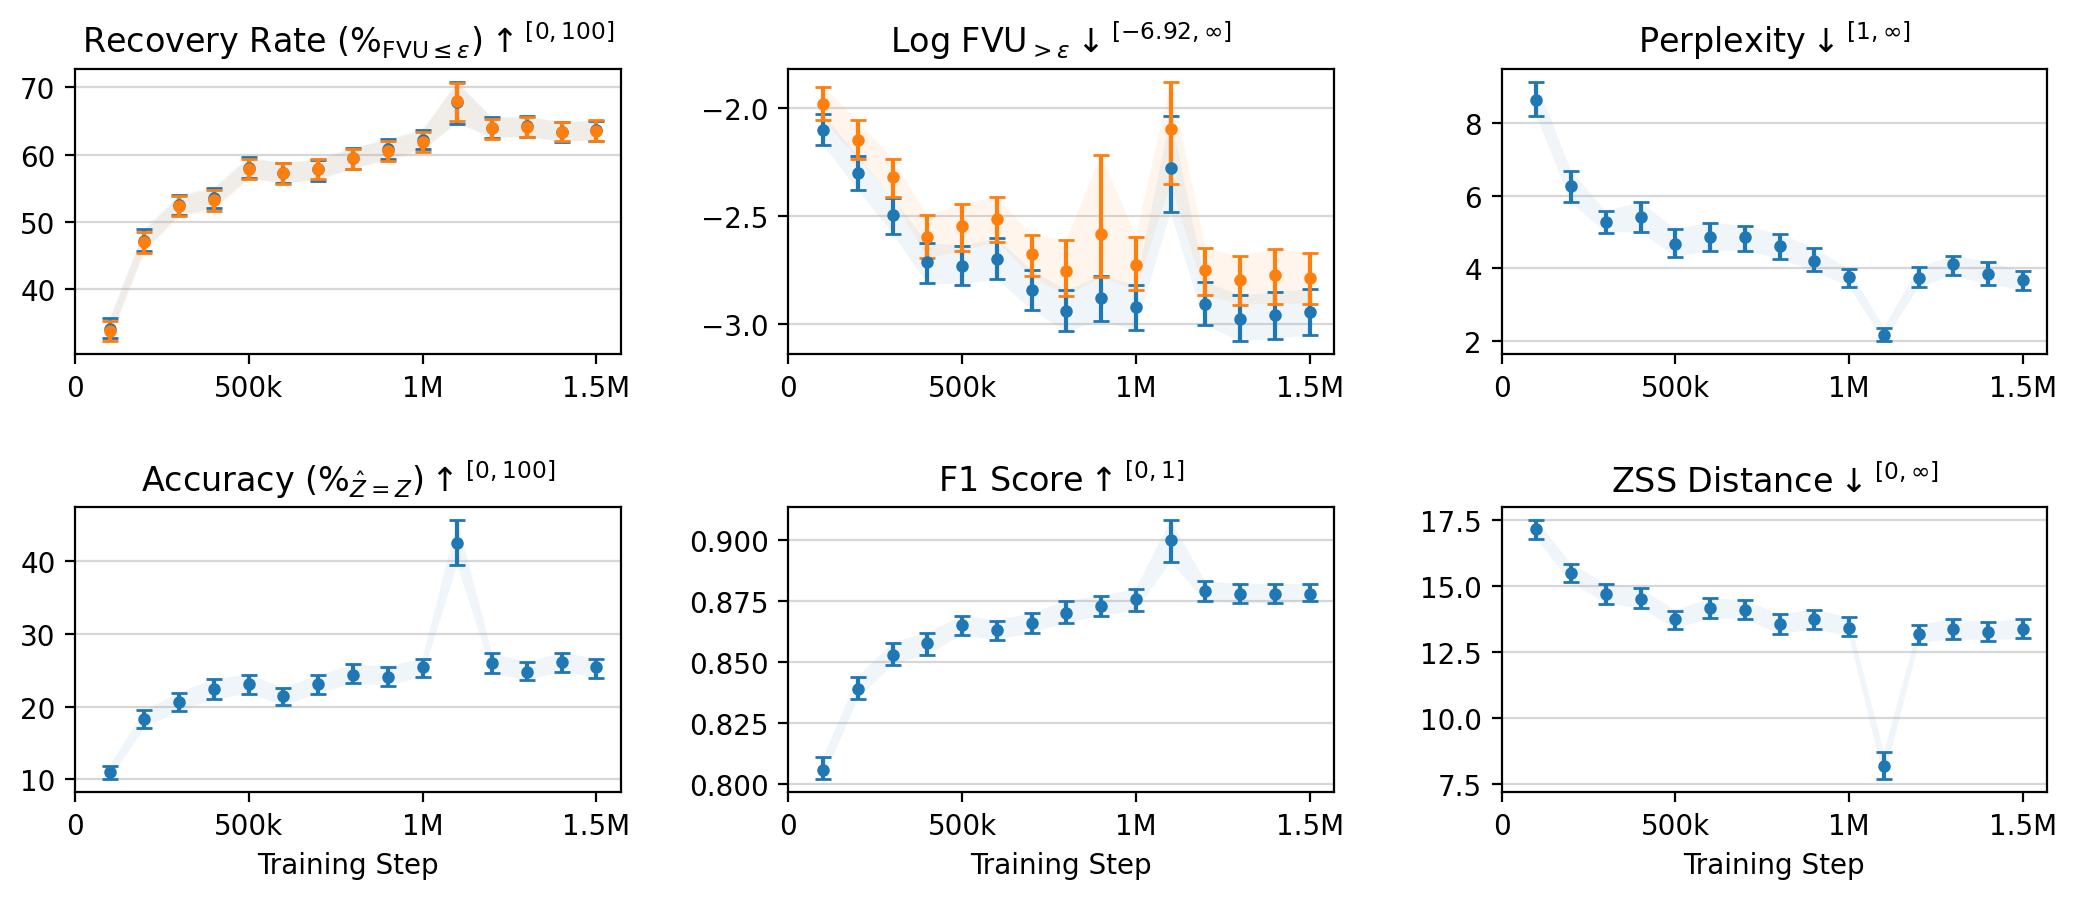

In [55]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'perplexity', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Perplexity', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (1, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'median', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
yscale_list = ['linear', 'linear', 'linear', 'linear', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None, (None, None), None, None, None, None]

x = [int(model.split('/')[1].split('-')[1]) for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):

    show_metrics = [show_metric]
    if f'{show_metric}_val' in total_summary_tables[sub_metric]['median'].T.index:
        show_metrics.append(f'{show_metric}_val')

    for k, (s, label) in enumerate(zip(show_metrics, ['Fit', 'Validation'])):
        y = total_summary_tables[sub_metric]['median'].T.loc[s] * factor
        y_lower = total_summary_tables[sub_metric]['lower'].T.loc[s] * factor
        y_upper = total_summary_tables[sub_metric]['upper'].T.loc[s] * factor

        ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3)
        sorted_indices = np.argsort(x)
        ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07)

    # ax.set_xscale('log', base=10)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    ax.set_xticks(np.array([0, 0.5, 1, 1.5]) * 1e6)
    ax.set_xticklabels(['0', '500k', '1M', '1.5M'])

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Training Step')
    # ax.set_xlabel('Beam Width')
    ax.grid(alpha=0.5, axis='y', which='both')

    ax.set_yscale(yscale)

    # if i == 2:
    #     ax.set_yticks(np.linspace(0, 1, 11).tolist())
    #     ax.set_yticklabels([f'A' for i in range(11)])

    ax.set_ylim(ylim)

    # if i == 1:
    #     # Annotate the first data point above the axis
    #     annotation = total_summary_tables[sub_metric]["median"].T.loc[show_metrics[0]]['analysis_points_v7.0/v7.0_1-points']
    #     ax.annotate(f'{annotation:.2f}', xy=(1, 0), xytext=(10, 1), textcoords='offset points', ha='right', va='bottom', color='tab:blue', fontsize=6)
        
    #     annotation = total_summary_tables[sub_metric]["median"].T.loc[show_metrics[1]]['analysis_points_v7.0/v7.0_1-points']
    #     ax.annotate(f'{annotation:.2f}', xy=(1, 0), xytext=(10, 8), textcoords='offset points', ha='right', va='bottom', color='tab:orange', fontsize=6)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_checkpoints', create=True, filename='analysis_checkpoints_errorbars.svg'))

In [47]:
sorted_models = sorted(MODELS, key=lambda x: int(x.split('/')[1].split('-')[1]))
sorted_models

['analysis_checkpoints_v7.0/v7.0_checkpoint-100000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-200000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-300000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-400000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-500000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-600000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-700000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-800000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-900000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-1000000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-1100000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-1200000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-1300000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-1400000',
 'analysis_checkpoints_v7.0/v7.0_checkpoint-1500000']